In [1]:
import time
import os, fnmatch
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from __future__ import print_function

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Conv2DTranspose, BatchNormalization, UpSampling2D, ZeroPadding2D
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
import numpy.random as rand

/home/arjung2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# create a list, result, of all file names
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

result = find('*.jpg', 'lfwfaces')
print("Number of images: " + str(len(result)))
print("Example file name: " + result[0])

Number of images: 13233
Example file name: lfwfaces/Aaron_Eckhart_0001.jpg


In [3]:
x_train = []

for i in range(len(result)):
    img = load_img(result[i])
    img = img_to_array(img)
    
    # convert from (250, 250, 3) to (256, 256, 3)
    new_img = []
    for j in range(250):
        arr = [[0, 0, 0]]
        arr = np.array(arr)

        vec = np.append(img[j], arr, axis=0)
        vec = np.append(vec, arr, axis=0)
        vec = np.append(vec, arr, axis=0)
        vec = np.append(vec, arr, axis=0)
        vec = np.append(vec, arr, axis=0)
        vec = np.append(vec, arr, axis=0)
        new_img.append(vec)

    new_img.append(vec)
    new_img.append(vec)
    new_img.append(vec)
    new_img.append(vec)
    new_img.append(vec)
    new_img.append(vec)
    new_img = np.array(new_img)
    
    img = (new_img - 127.5) / 127.5
    x_train.append(img)
    
x_train = np.array(x_train)
print("x_train.shape = " + str(x_train.shape))

x_train.shape = (13233, 256, 256, 3)


Example image shape: (256, 256, 3)
Example image: 


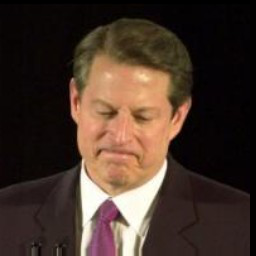

In [4]:
print("Example image shape: " + str(x_train[334].shape))
print("Example image: ")
img = array_to_img(x_train[334])
display(img)

In [5]:
def get_batch(size):
    
    arr = []
    
    for _ in range(size):
        
        k = rand.randint(0, 13233)
        arr.append(x_train[k])
    
    return np.array(arr)

In [6]:
# Generator

input_shape = (1, 1, 100)

generator = Sequential()

generator.add(UpSampling2D(size=(2, 2), input_shape=input_shape)) # 100 x 2 x 2
generator.add(Conv2D(64,(6,6),activation='relu',padding='same')) # 4 x 2 x 2
generator.add(BatchNormalization(momentum=0.8))

generator.add(UpSampling2D(2)) # 4 x 4 x 4
generator.add(Conv2D(96,(6,6),activation='relu',padding='same')) # 8 x 4 x 4
generator.add(BatchNormalization(momentum=0.8))

generator.add(UpSampling2D(2)) # 8 x 8 x 8
generator.add(Conv2D(128,(6,6),activation='relu',padding='same')) # 16 x 8 x 8
generator.add(BatchNormalization(momentum=0.8))

generator.add(UpSampling2D(2)) # 16 x 16 x 16
generator.add(Conv2D(160,(6,6),activation='relu',padding='same')) # 32 x 16 x 16
generator.add(BatchNormalization(momentum=0.8))

generator.add(UpSampling2D(2)) # 32 x 32 x 32
generator.add(Conv2D(192,(6,6),activation='relu',padding='same')) # 64 x 32 x 32
generator.add(BatchNormalization(momentum=0.8))

generator.add(UpSampling2D(2)) # 64 x 64 x 64
generator.add(Conv2D(224,(6,6),activation='relu',padding='same')) # 128 x 64 x 64
generator.add(BatchNormalization(momentum=0.8))

generator.add(UpSampling2D(2)) # 128 x 128 x 128
generator.add(Conv2D(256,(6,6),activation='relu',padding='same')) # 256 x 128 x 128
generator.add(BatchNormalization(momentum=0.8))

generator.add(UpSampling2D(2)) # 256 x 256 x 256
generator.add(Conv2D(3,(6,6),activation='tanh',padding='same')) # 3 x 256 x 256


# Discriminator

img_shape = (256, 256, 3)

discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Flatten()) # (None, 1024)

discriminator.add(Dense(1,activation="sigmoid",kernel_regularizer=l2(1e-3))) # (None, 1)

In [7]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 2, 2, 100)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          230464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 64)          256       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 96)          221280    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 96)          384       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 8, 8, 96)          0         
__________

In [8]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 65, 65, 128)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 65, 65, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 65, 65, 128)       0         
__________

In [9]:
# GAN

# gan input (noise) will be 100-dimensional vectors
gan_input = Input(shape=input_shape)

gan = Model(inputs = gan_input, outputs = discriminator(generator(gan_input)) )

gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00002, beta_1=0.5))

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00002, beta_1=0.5))



--------------- Epoch: 0 ---------------


/home/arjung2/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator loss: 2.7828152, GAN loss: 0.11314243

Discriminator loss: 1.8962238, GAN loss: 0.36298078

Discriminator loss: 1.2151521, GAN loss: 0.3417332

Discriminator loss: 0.7257051, GAN loss: 0.41082352

Discriminator loss: 0.41457197, GAN loss: 0.10779107

Discriminator loss: 0.454354, GAN loss: 0.058947477

Discriminator loss: 0.11045226, GAN loss: 0.13560441

Discriminator loss: 0.16833186, GAN loss: 0.01964755

Discriminator loss: 0.023676524, GAN loss: 0.024187779

Loss History:


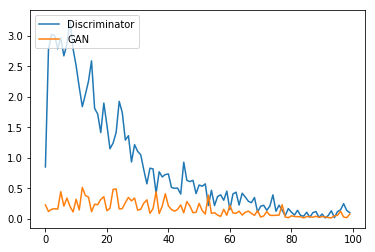

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


An Example from the Training Set: 


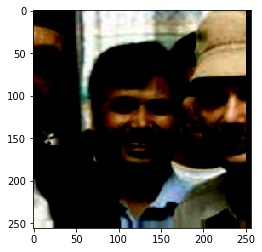

An Example from the Generator: 


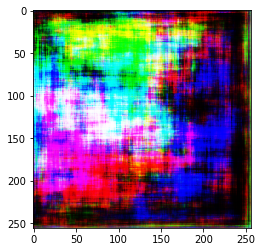

Prediction: [0.9997795]


--------------- Epoch: 1 ---------------
Discriminator loss: 0.061841886, GAN loss: 0.06348041

Discriminator loss: 0.021089943, GAN loss: 0.050084345

Discriminator loss: 0.015746051, GAN loss: 0.00515453

Discriminator loss: 0.048345886, GAN loss: 0.0077231685

Discriminator loss: 0.06665795, GAN loss: 0.009026047

Discriminator loss: 0.038392246, GAN loss: 0.012928014

Discriminator loss: 0.06918632, GAN loss: 0.014396799

Discriminator loss: 0.04349078, GAN loss: 0.007486843

Discriminator loss: 0.06497665, GAN loss: 0.019278565

Loss History:


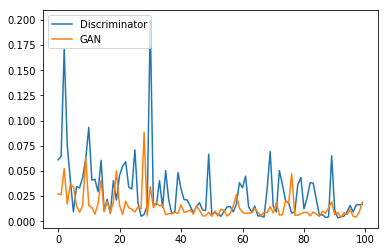

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


An Example from the Training Set: 


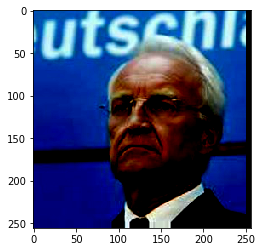

An Example from the Generator: 


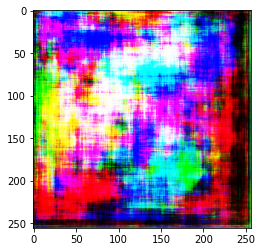

Prediction: [0.9999578]


--------------- Epoch: 2 ---------------
Discriminator loss: 0.005023011, GAN loss: 0.005536844

Discriminator loss: 0.0059757982, GAN loss: 0.0049313977

Discriminator loss: 0.004228802, GAN loss: 0.00575432

Discriminator loss: 0.0036545321, GAN loss: 0.008233136

Discriminator loss: 0.0048895776, GAN loss: 0.005158301

Discriminator loss: 0.0056687235, GAN loss: 0.0026891395

Discriminator loss: 0.00262139, GAN loss: 0.0037554307

Discriminator loss: 0.005756058, GAN loss: 0.003771787

Discriminator loss: 0.017390927, GAN loss: 0.0036230995

Loss History:


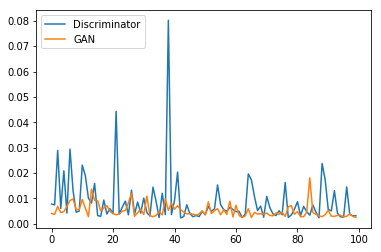

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


An Example from the Training Set: 


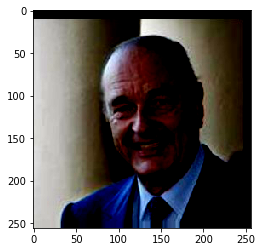

An Example from the Generator: 


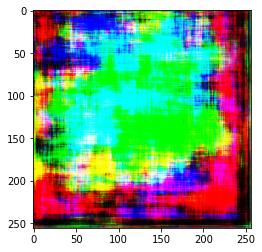

Prediction: [0.9999913]


--------------- Epoch: 3 ---------------
Discriminator loss: 0.0033847988, GAN loss: 0.014813583

Discriminator loss: 0.003027273, GAN loss: 0.0029373283

Discriminator loss: 0.0058914195, GAN loss: 0.0026614142

Discriminator loss: 0.0026900251, GAN loss: 0.003015438

Discriminator loss: 0.007879232, GAN loss: 0.003079977

Discriminator loss: 0.002396224, GAN loss: 0.0037600878

Discriminator loss: 0.0037860253, GAN loss: 0.0032416582

Discriminator loss: 0.005891659, GAN loss: 0.0028319233

Discriminator loss: 0.0062345797, GAN loss: 0.003427493

Loss History:


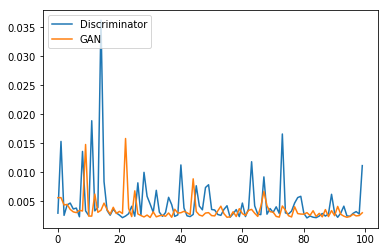

An Example from the Training Set: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


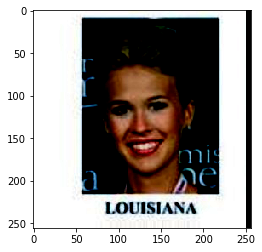

An Example from the Generator: 


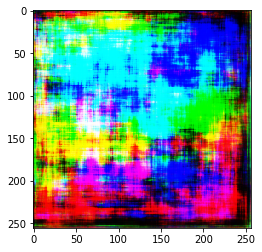

Prediction: [0.99999654]


--------------- Epoch: 4 ---------------
Discriminator loss: 0.0029187235, GAN loss: 0.0025432166

Discriminator loss: 0.002606468, GAN loss: 0.0024862613

Discriminator loss: 0.002389436, GAN loss: 0.0024340153

Discriminator loss: 0.0028376298, GAN loss: 0.0028270169

Discriminator loss: 0.011799405, GAN loss: 0.0021968938

Discriminator loss: 0.0022240267, GAN loss: 0.0032891359

Discriminator loss: 0.0022194835, GAN loss: 0.0024278017

Discriminator loss: 0.00898312, GAN loss: 0.002179406

Discriminator loss: 0.0024539598, GAN loss: 0.0022543415

Loss History:


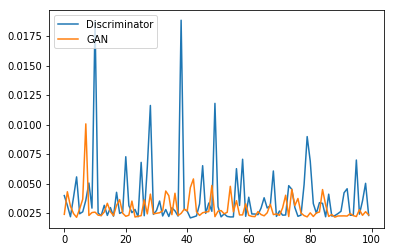

An Example from the Training Set: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


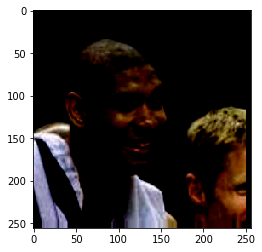

An Example from the Generator: 


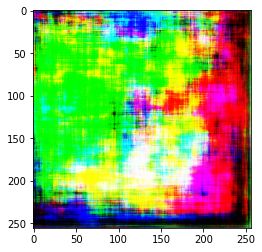

Prediction: [0.99999857]


--------------- Epoch: 5 ---------------
Discriminator loss: 0.0033143118, GAN loss: 0.0023794663

Discriminator loss: 0.0033022407, GAN loss: 0.002447361

Discriminator loss: 0.0022328817, GAN loss: 0.0032700566

Discriminator loss: 0.0034788162, GAN loss: 0.002752837

Discriminator loss: 0.002578799, GAN loss: 0.0023630424

Discriminator loss: 0.0021289487, GAN loss: 0.00239849

Discriminator loss: 0.0023168095, GAN loss: 0.0024411124

Discriminator loss: 0.0048900084, GAN loss: 0.0022824267

Discriminator loss: 0.0023210505, GAN loss: 0.002119578

Loss History:


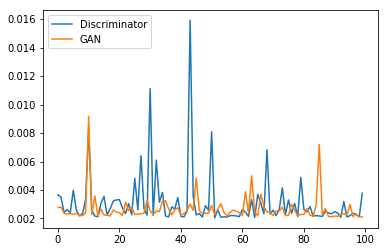

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


An Example from the Training Set: 


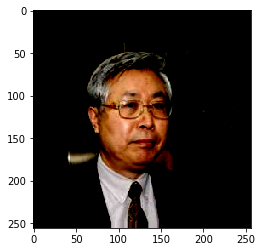

An Example from the Generator: 


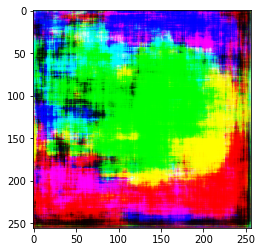

Prediction: [0.99999714]


--------------- Epoch: 6 ---------------
Discriminator loss: 0.002218178, GAN loss: 0.0021133383

Discriminator loss: 0.0036832143, GAN loss: 0.002161608

Discriminator loss: 0.00232043, GAN loss: 0.0024259896

Discriminator loss: 0.0022098187, GAN loss: 0.0021878195

Discriminator loss: 0.0021798154, GAN loss: 0.002579029

Discriminator loss: 0.002483529, GAN loss: 0.0021341925

Discriminator loss: 0.0028313042, GAN loss: 0.0024288497

Discriminator loss: 0.0026852218, GAN loss: 0.0027849162

Discriminator loss: 0.0022467072, GAN loss: 0.002167089

Loss History:


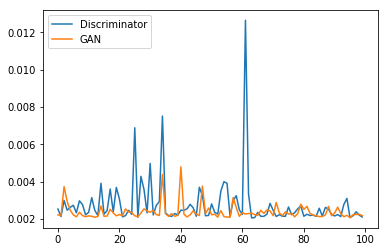

An Example from the Training Set: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


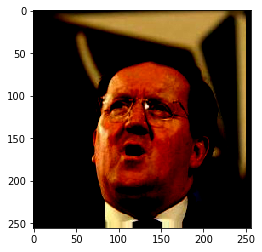

An Example from the Generator: 


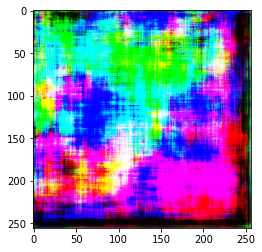

Prediction: [0.999998]


--------------- Epoch: 7 ---------------
Discriminator loss: 0.006941478, GAN loss: 0.0021794045

Discriminator loss: 0.002483221, GAN loss: 0.0021833272

Discriminator loss: 0.002256595, GAN loss: 0.0024116938

Discriminator loss: 0.0024202487, GAN loss: 0.0021005843

Discriminator loss: 0.0022499554, GAN loss: 0.0021247128

Discriminator loss: 0.0026636869, GAN loss: 0.002386325

Discriminator loss: 0.0020884562, GAN loss: 0.0020592846

Discriminator loss: 0.002057291, GAN loss: 0.0021123462

Discriminator loss: 0.0027070341, GAN loss: 0.0040664976

Loss History:


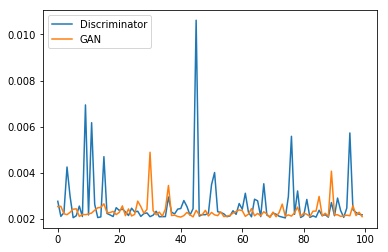

An Example from the Training Set: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


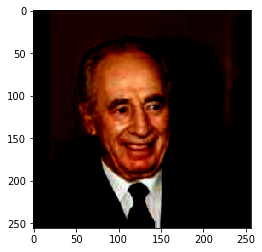

An Example from the Generator: 


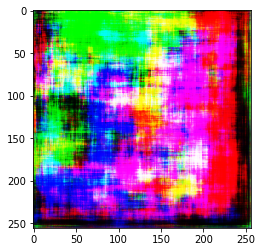

Prediction: [0.99999976]


--------------- Epoch: 8 ---------------
Discriminator loss: 0.0024347308, GAN loss: 0.0020910415

Discriminator loss: 0.0020740896, GAN loss: 0.0022708746

Discriminator loss: 0.0020565188, GAN loss: 0.0021269305

Discriminator loss: 0.002358069, GAN loss: 0.002282219

Discriminator loss: 0.0021567745, GAN loss: 0.0022429158

Discriminator loss: 0.0021010984, GAN loss: 0.002090511

Discriminator loss: 0.0022052068, GAN loss: 0.0020960246

Discriminator loss: 0.0021101765, GAN loss: 0.002132613

Discriminator loss: 0.0020758936, GAN loss: 0.0021790906

Loss History:


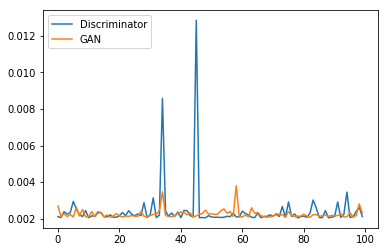

An Example from the Training Set: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


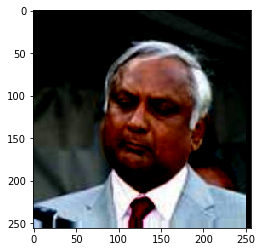

An Example from the Generator: 


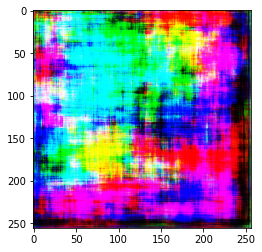

Prediction: [0.99999905]


--------------- Epoch: 9 ---------------
Discriminator loss: 0.0020603563, GAN loss: 0.0022305741

Discriminator loss: 0.0022906377, GAN loss: 0.0021476164

Discriminator loss: 0.002043743, GAN loss: 0.0027803439

Discriminator loss: 0.0021220606, GAN loss: 0.0023222147

Discriminator loss: 0.00205197, GAN loss: 0.0020803353

Discriminator loss: 0.0021928377, GAN loss: 0.0020738961

Discriminator loss: 0.0020774824, GAN loss: 0.0027816345

Discriminator loss: 0.0020461977, GAN loss: 0.0021402596

Discriminator loss: 0.002287215, GAN loss: 0.0021132396

Loss History:


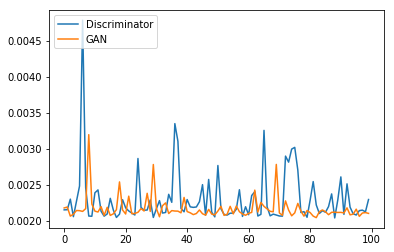

An Example from the Training Set: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


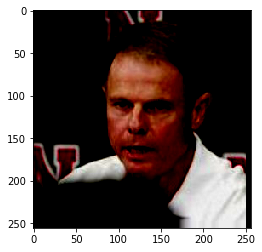

An Example from the Generator: 


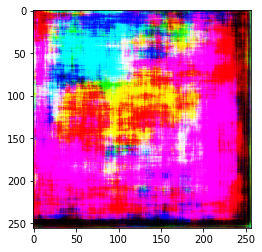

Prediction: [0.9999918]


In [10]:
epochs = 10
batch_size = 10

for i in range(epochs):
    
    print("\n")
    print('-'*15, 'Epoch: ' + str(i), '-'*15)
    
    x_train_batch = get_batch(1000)
    
    # Number of batches
    batch_count = x_train_batch.shape[0] / batch_size
    
    start = 0
    end = batch_size
    
    d_loss = 0
    g_loss = 0
    g_loss_arr = []
    d_loss_arr = []
        
    for j in range(int(batch_count)):
        
        if j % 10 == 0 and j != 0:
            # print(".", end="")
            print("Discriminator loss: " + str(d_loss) + ", GAN loss: " + str(g_loss) + "\n")
        
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size, 1, 1, 100])        
        image_batch = x_train_batch[start:end]
        image_batch = np.reshape(image_batch, (batch_size, 256, 256, 3))
        
        # Generate fake images
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images])

        # Labels for generated and real data
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 1

        # Train discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y_dis)
        
        # d_history = discriminator.fit(X, y_dis)
        d_loss_arr.append(d_loss)

        # Train generator
        noise = np.random.normal(0, 1, size=[batch_size, 1, 1, 100])
        # The y-label will be 1 since we want to train the generator such that the GAN gives out 1
        y_gen = np.ones(batch_size)
        
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        g_loss_arr.append(g_loss)
        
        # Update start and end
        start += batch_size
        end += batch_size

    # Display loss history
    print("Loss History:")
    plt.plot(d_loss_arr, label = 'Discriminator')
    plt.plot(g_loss_arr, label = 'GAN')
    plt.legend(loc='upper left')
    plt.show()
    
    # Display a sample of the results
    noise = np.random.normal(0, 1, size=[1, 1, 1, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images * 0.5 + 0.5

    arr = discriminator.predict(generated_images)
    generated_images = generated_images.reshape(1, 256, 256, 3)
    generated_images = np.clip(generated_images, 0, 1)

    k = rand.randint(0, batch_size)
    print("An Example from the Training Set: ")
    plt.imshow(image_batch[k], vmin=0, vmax=1)
    plt.show()
    print("An Example from the Generator: ")
    plt.imshow(generated_images[0], vmin=0, vmax=1)
    plt.show()
    print("Prediction: " + str(arr[0]))